In [1]:
# notebook dependencies
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 500

import os # for caching purposeses
import pandas as pd
import numpy as np

# visualization imports
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# plotly module/library
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "notebook_connected"

# importing acquire and prepapre.py files
from acquire import get_reddit_stress
import prepare
from prepare import mass_text_clean

# regular expression import
import re

# JSON import
import json

# importing BeautifulSoup for parsing HTML/XTML
from bs4 import BeautifulSoup

# request module for connecting to APIs
from requests import get

# uni-code library
import unicodedata

# natural language toolkit library/modules
import nltk
from nltk.stem import PorterStemmer, LancasterStemmer, WordNetLemmatizer

from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords

from pprint import pprint

In [2]:
# obtain subreddit text data 

def get_reddit_stress():
    # cached filename to look for
    filename = "stress.csv"

    # search for filename in local/OS directory
    if os.path.isfile(filename):

        # if file and filename exists, then return csv as Pandas df
        # future iteration: consider using relative path 
        # this may help to prevent referencing deleted/incorrect files
        df = pd.read_csv(filename, index_col = "social_timestamp")

        # print df shape
        print(f'dataframe shape: {df.shape}')

        # return the dataframe
        return df

    # if file/csv can't be found in OS directory, then access the data and cache it as a csv locally
    else:

        url = "https://raw.githubusercontent.com/amankharwal/Website-data/master/stress.csv"
        # read text data as csv and convert to pandas dataframe
        df = pd.read_csv(url)

        # let's move forward with just the following columns/features
        df = df[[
            "label", 
            "post_id",
            "subreddit",                                 
            "sentence_range",              
            "text",                        
            "id",              
            "confidence",            
            "social_timestamp",           
            "social_karma",                
            "syntax_ari",
            "sentiment",
            "social_upvote_ratio",
            "social_num_comments"
            ]]

        # timestamp appears to be in "epoch seconds format"
        df["social_timestamp"] = pd.to_datetime(df['social_timestamp'], unit = 's')

        # sort and set data as index
        df.set_index('social_timestamp', inplace = True)

        # cache the data for easier/quicker reference
        df.to_csv("stress.csv")

        # print the shape
        print(f'dataframe shape: {df.shape}')

        # return the dataframe
        return df

In [3]:
# testing out the created function 

df = get_reddit_stress()
df.head()

dataframe shape: (2838, 12)


,label,post_id,subreddit,sentence_range,text,id,confidence,social_karma,syntax_ari,sentiment,social_upvote_ratio,social_num_comments
social_timestamp,,,,,,,,,,,,
2018-03-21 06:39:13,1,8601tu,ptsd,"(15, 20)","He said he had not felt that way before, sugge...",33181,0.8,5,1.806818,-0.002742,0.86,1
2018-05-22 17:23:37,0,8lbrx9,assistance,"(0, 5)","Hey there r/assistance, Not sure if this is th...",2606,1.0,4,9.429737,0.292857,0.65,2
2018-09-03 00:46:45,1,9ch1zh,ptsd,"(15, 20)",My mom then hit me with the newspaper and it s...,38816,0.8,2,7.769821,0.011894,0.67,0
2018-01-20 06:25:55,1,7rorpp,relationships,"[5, 10]","until i met my new boyfriend, he is amazing, h...",239,0.6,0,2.667798,0.141671,0.50,5
2018-10-17 20:43:25,1,9p2gbc,survivorsofabuse,"[0, 5]",October is Domestic Violence Awareness Month a...,1421,0.8,24,7.554238,-0.204167,1.00,1


In [4]:
# df info

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2838 entries, 2018-03-21 06:39:13 to 2017-03-07 17:58:36
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   label                2838 non-null   int64  
 1   post_id              2838 non-null   object 
 2   subreddit            2838 non-null   object 
 3   sentence_range       2838 non-null   object 
 4   text                 2838 non-null   object 
 5   id                   2838 non-null   int64  
 6   confidence           2838 non-null   float64
 7   social_karma         2838 non-null   int64  
 8   syntax_ari           2838 non-null   float64
 9   sentiment            2838 non-null   float64
 10  social_upvote_ratio  2838 non-null   float64
 11  social_num_comments  2838 non-null   int64  
dtypes: float64(4), int64(4), object(4)
memory usage: 288.2+ KB


In [5]:
# df shape

df.shape

(2838, 12)

In [6]:
# column names to list

df.columns.tolist()

['label',
 'post_id',
 'subreddit',
 'sentence_range',
 'text',
 'id',
 'confidence',
 'social_karma',
 'syntax_ari',
 'sentiment',
 'social_upvote_ratio',
 'social_num_comments']

In [7]:
# what is the percentage of missing values by ea. column/feature?

with pd.option_context("display.max_rows", False):
    print(df.isnull().mean()) # no features contain missing values

label                  0.0
post_id                0.0
subreddit              0.0
sentence_range         0.0
text                   0.0
id                     0.0
confidence             0.0
social_karma           0.0
syntax_ari             0.0
sentiment              0.0
social_upvote_ratio    0.0
social_num_comments    0.0
dtype: float64


In [8]:
# # let's move forward with the following columns/features

# df = df[[
#     "label", 
#     "post_id",
#     "subreddit",                                 
#     "sentence_range",              
#     "text",                        
#     "id",              
#     "confidence",            
#     "social_timestamp",           
#     "social_karma",                
#     "syntax_ari",
#     "sentiment",
#     "social_upvote_ratio",
#     "social_num_comments"
#     ]]

# df.shape 

In [9]:
# cache text data as csv for easier accessing

# df.to_csv("stress.csv")

In [10]:
# check the head

# df = pd.read_csv("stress.csv", index_col = True)

In [11]:
# let's look at the "social_timestamp" feature 
# timestamp appears to be in "epoch seconds format"

# df["social_timestamp"] = pd.to_datetime(df['social_timestamp'], unit = 's')
# df["social_timestamp"].head() # checks out!

In [12]:
# check the df info

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2838 entries, 2018-03-21 06:39:13 to 2017-03-07 17:58:36
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   label                2838 non-null   int64  
 1   post_id              2838 non-null   object 
 2   subreddit            2838 non-null   object 
 3   sentence_range       2838 non-null   object 
 4   text                 2838 non-null   object 
 5   id                   2838 non-null   int64  
 6   confidence           2838 non-null   float64
 7   social_karma         2838 non-null   int64  
 8   syntax_ari           2838 non-null   float64
 9   sentiment            2838 non-null   float64
 10  social_upvote_ratio  2838 non-null   float64
 11  social_num_comments  2838 non-null   int64  
dtypes: float64(4), int64(4), object(4)
memory usage: 288.2+ KB


In [13]:
# set timestamp as index

# df = df.set_index(pd.DatetimeIndex(df['social_timestamp']))
# df.head()

In [14]:
# check the head

df.head()

,label,post_id,subreddit,sentence_range,text,id,confidence,social_karma,syntax_ari,sentiment,social_upvote_ratio,social_num_comments
social_timestamp,,,,,,,,,,,,
2018-03-21 06:39:13,1,8601tu,ptsd,"(15, 20)","He said he had not felt that way before, sugge...",33181,0.8,5,1.806818,-0.002742,0.86,1
2018-05-22 17:23:37,0,8lbrx9,assistance,"(0, 5)","Hey there r/assistance, Not sure if this is th...",2606,1.0,4,9.429737,0.292857,0.65,2
2018-09-03 00:46:45,1,9ch1zh,ptsd,"(15, 20)",My mom then hit me with the newspaper and it s...,38816,0.8,2,7.769821,0.011894,0.67,0
2018-01-20 06:25:55,1,7rorpp,relationships,"[5, 10]","until i met my new boyfriend, he is amazing, h...",239,0.6,0,2.667798,0.141671,0.50,5
2018-10-17 20:43:25,1,9p2gbc,survivorsofabuse,"[0, 5]",October is Domestic Violence Awareness Month a...,1421,0.8,24,7.554238,-0.204167,1.00,1


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2838 entries, 2018-03-21 06:39:13 to 2017-03-07 17:58:36
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   label                2838 non-null   int64  
 1   post_id              2838 non-null   object 
 2   subreddit            2838 non-null   object 
 3   sentence_range       2838 non-null   object 
 4   text                 2838 non-null   object 
 5   id                   2838 non-null   int64  
 6   confidence           2838 non-null   float64
 7   social_karma         2838 non-null   int64  
 8   syntax_ari           2838 non-null   float64
 9   sentiment            2838 non-null   float64
 10  social_upvote_ratio  2838 non-null   float64
 11  social_num_comments  2838 non-null   int64  
dtypes: float64(4), int64(4), object(4)
memory usage: 288.2+ KB


In [16]:
# data familiarization/exploration 
# let's look at ea. individual feature/column and their respective values

for col in df.columns:
    if col != "text":
        print(f'feature name: {col}')
        print(f'data type: {df[col].dtype}')
        print(f'number of unique values: {df[col].nunique()}')
        print(f'value samples: {df[col].sample(10).unique()}')
        print('------------------------------------------------------')

feature name: label
data type: int64
number of unique values: 2
value samples: [1 0]
------------------------------------------------------
feature name: post_id
data type: object
number of unique values: 2343
value samples: ['7ymj1a' '7su5yv' '7nhofe' '80k6cw' '5wms9t' '8n761h' '9fc7wk' '8wouin'
 '7m5752' '7ztiy0']
------------------------------------------------------
feature name: subreddit
data type: object
number of unique values: 10
value samples: ['survivorsofabuse' 'relationships' 'ptsd' 'anxiety' 'domesticviolence']
------------------------------------------------------
feature name: sentence_range
data type: object
number of unique values: 173
value samples: ['(20, 25)' '[33, 38]' '[45, 50]' '(0, 5)' '[0, 5]' '[5, 10]']
------------------------------------------------------
feature name: id
data type: int64
number of unique values: 2838
value samples: [ 4819  9125   492 19691 41461 36988 14795   144 33502   476]
------------------------------------------------------
feature n

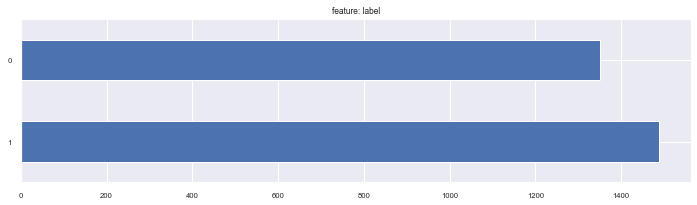

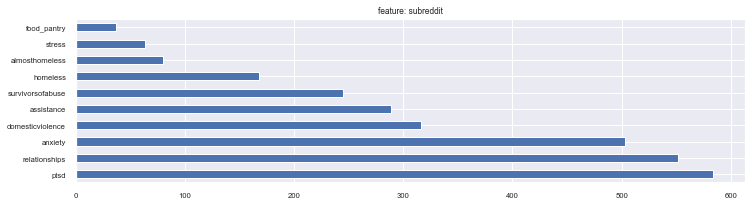

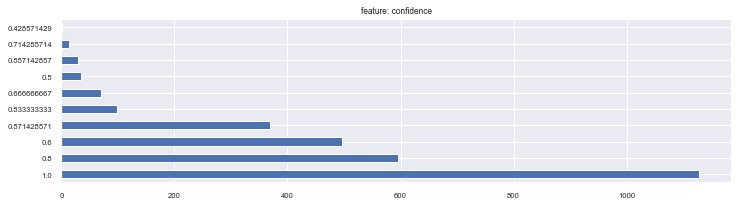

In [17]:
# let's plot a by column value counts

for col in df.columns:
    if df[col].nunique() <= 25:
        plt.figure(figsize = (12,3))
        sns.set(font_scale = 0.7)

        df[col].value_counts().plot(kind = "barh")

        plt.title(f'feature: {col}')
        plt.show()

### ``what about subreddit topics over time?``

In [18]:
# let's first look at the time span 
# viewing latest date first

df.index.max()

'2018-11-19 01:54:20'

In [19]:
# earliest date

df.index.min()

'2017-01-01 12:36:58'

In [20]:
# creating a month and year column 

df['month_year'] = pd.to_datetime(df.index).to_period('M')
df.head()

,label,post_id,subreddit,sentence_range,text,id,confidence,social_karma,syntax_ari,sentiment,social_upvote_ratio,social_num_comments,month_year
social_timestamp,,,,,,,,,,,,,
2018-03-21 06:39:13,1,8601tu,ptsd,"(15, 20)","He said he had not felt that way before, sugge...",33181,0.8,5,1.806818,-0.002742,0.86,1,2018-03
2018-05-22 17:23:37,0,8lbrx9,assistance,"(0, 5)","Hey there r/assistance, Not sure if this is th...",2606,1.0,4,9.429737,0.292857,0.65,2,2018-05
2018-09-03 00:46:45,1,9ch1zh,ptsd,"(15, 20)",My mom then hit me with the newspaper and it s...,38816,0.8,2,7.769821,0.011894,0.67,0,2018-09
2018-01-20 06:25:55,1,7rorpp,relationships,"[5, 10]","until i met my new boyfriend, he is amazing, h...",239,0.6,0,2.667798,0.141671,0.50,5,2018-01
2018-10-17 20:43:25,1,9p2gbc,survivorsofabuse,"[0, 5]",October is Domestic Violence Awareness Month a...,1421,0.8,24,7.554238,-0.204167,1.00,1,2018-10


In [21]:
# sort df by index timestamp

df = df.sort_index(ascending = True)
df.head()

,label,post_id,subreddit,sentence_range,text,id,confidence,social_karma,syntax_ari,sentiment,social_upvote_ratio,social_num_comments,month_year
social_timestamp,,,,,,,,,,,,,
2017-01-01 12:36:58,1,5lezhz,domesticviolence,"[14, 19]",He came after me a few times so I got away and...,313,0.571429,4,0.531035,0.076333,0.84,3,2017-01
2017-01-01 12:36:58,1,5lezhz,domesticviolence,"(5, 10)","We will get through this and I am determined, ...",31536,0.857143,4,8.679730,0.047222,0.84,3,2017-01
2017-01-01 18:35:06,1,5lge1y,anxiety,"(0, 5)",Currently in s constant state of anxiety with ...,7419,1.000000,14,7.822923,-0.083333,0.94,8,2017-01
2017-01-03 16:10:28,1,5lspep,survivorsofabuse,"(5, 10)",I was having a fucking panic attack.Once we pa...,18404,1.000000,5,0.633660,-0.466667,0.86,7,2017-01
2017-01-03 22:13:10,1,5luwz3,almosthomeless,"[10, 15]",I am afraid that she will sell the house becau...,1804,0.800000,5,2.823077,-0.401250,0.65,15,2017-01


In [22]:
# renaming several subreddit titles for clarification

df["subreddit"].replace({
    'almosthomeless': "almost_homeless",
    'domesticviolence': "domestic_violence",
    'survivorsofabuse': 'abuse_survivors'
}, inplace = True)

df["subreddit"].unique()

array(['domestic_violence', 'anxiety', 'abuse_survivors',
       'almost_homeless', 'homeless', 'ptsd', 'stress', 'assistance',
       'food_pantry', 'relationships'], dtype=object)

In [23]:
# plotting subreddit topics over time

test_df = pd.get_dummies(df["subreddit"])
test_df.index = pd.to_datetime(test_df.index)
test_df.head()

,abuse_survivors,almost_homeless,anxiety,assistance,domestic_violence,food_pantry,homeless,ptsd,relationships,stress
social_timestamp,,,,,,,,,,
2017-01-01 12:36:58,0,0,0,0,1,0,0,0,0,0
2017-01-01 12:36:58,0,0,0,0,1,0,0,0,0,0
2017-01-01 18:35:06,0,0,1,0,0,0,0,0,0,0
2017-01-03 16:10:28,1,0,0,0,0,0,0,0,0,0
2017-01-03 22:13:10,0,1,0,0,0,0,0,0,0,0


In [24]:
# create a list of subreddit column/feature names

test_cols = test_df.columns.tolist()
test_cols

['abuse_survivors',
 'almost_homeless',
 'anxiety',
 'assistance',
 'domestic_violence',
 'food_pantry',
 'homeless',
 'ptsd',
 'relationships',
 'stress']

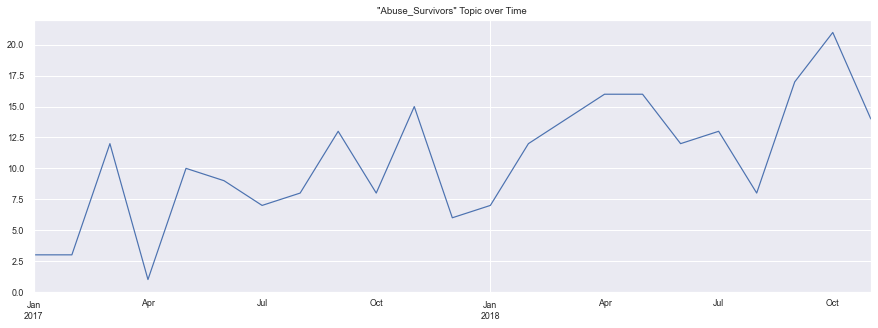

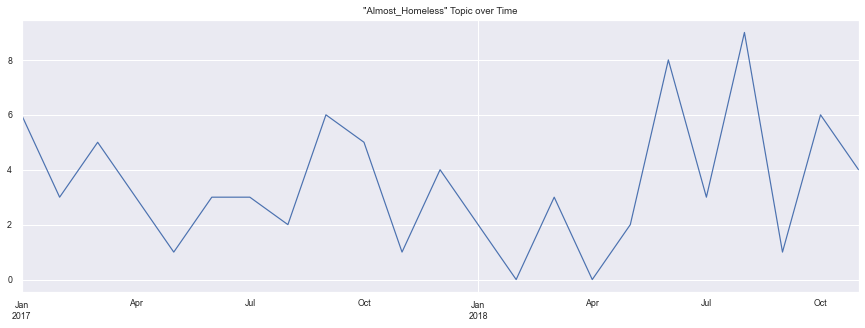

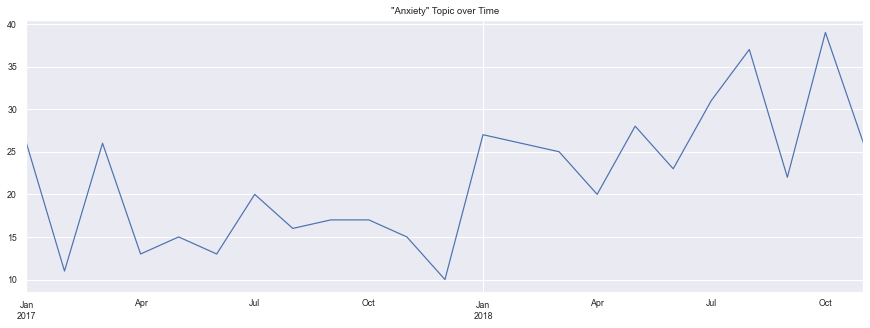

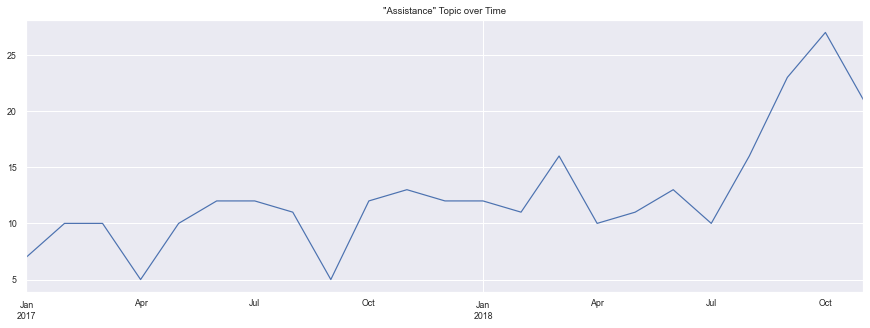

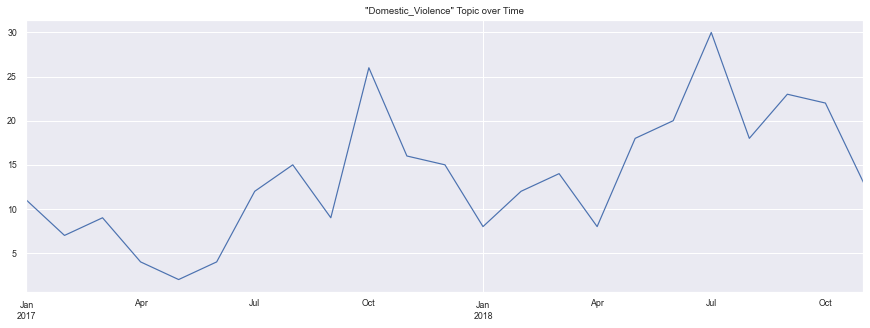

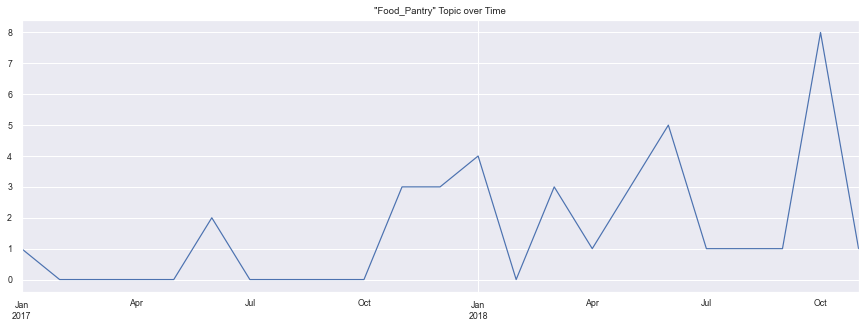

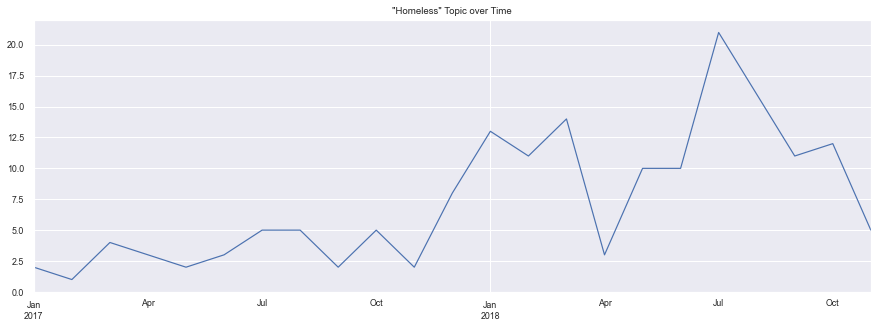

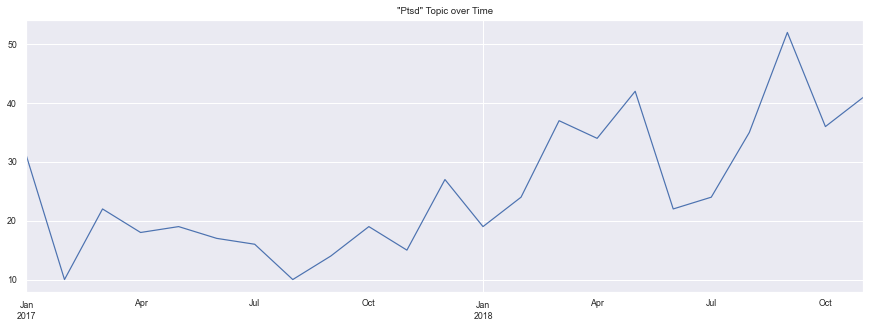

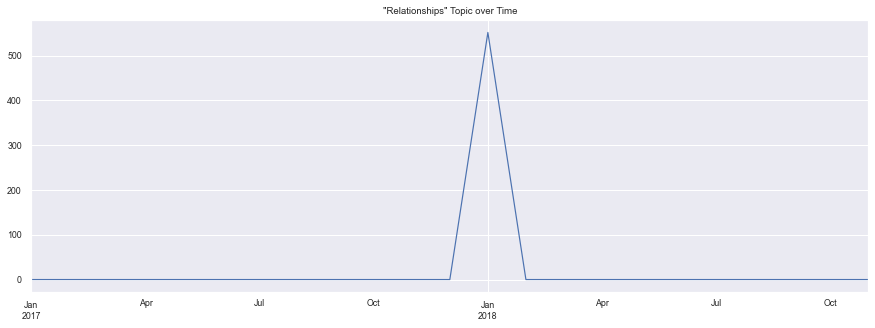

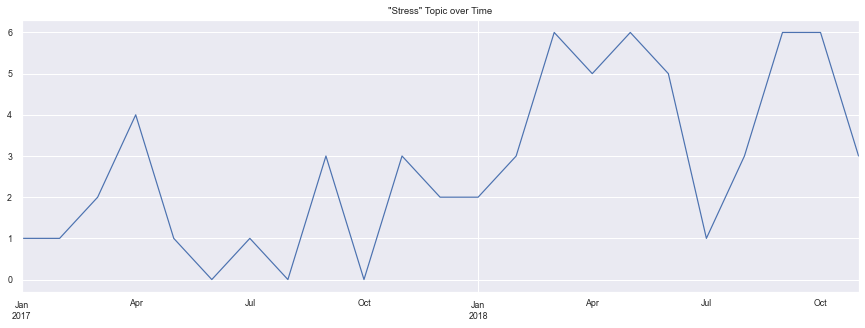

In [25]:
# let's plot the distinct total number of subreddit topics over time

for col in test_cols:
    plt.figure(figsize = (15, 5))
    plt.style.use('ggplot')
    sns.set(font_scale = 0.8)

    test_df[col].resample("M").sum().plot(kind = "line", linewidth = 1.2)
    plt.xlabel(None)

    plt.title(f'"{col.title()}" Topic over Time')
    plt.show()

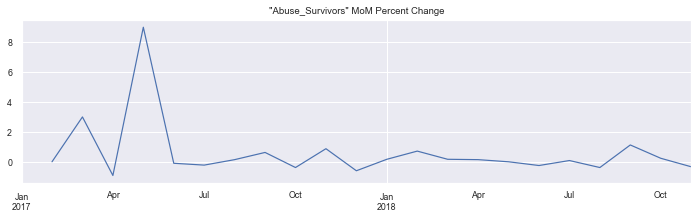

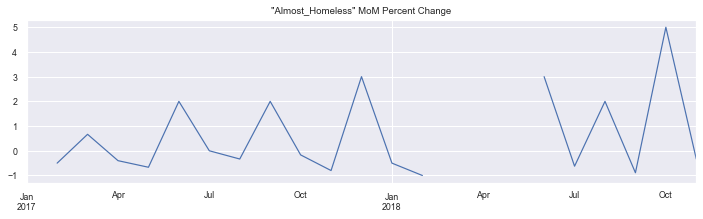

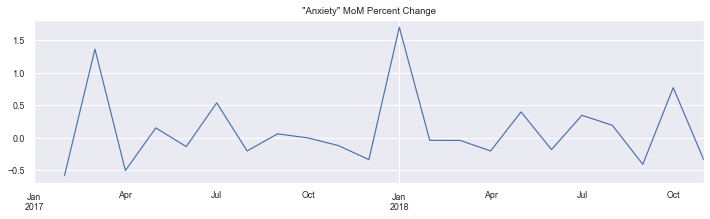

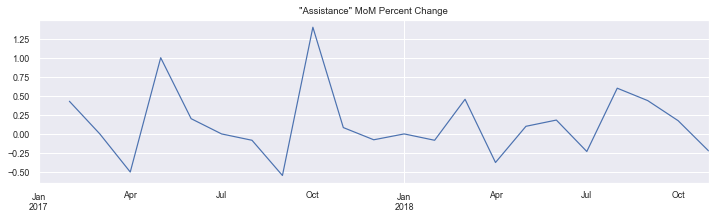

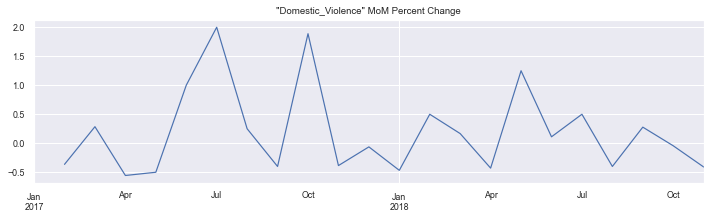

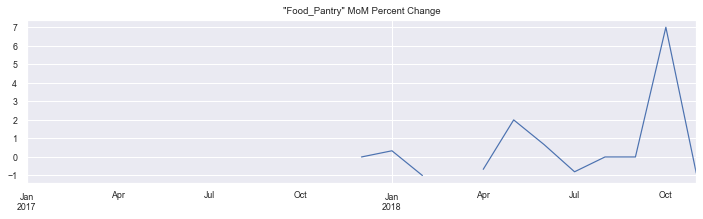

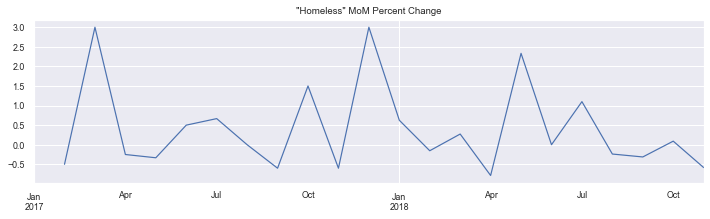

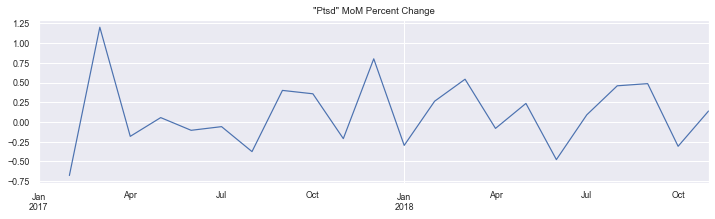

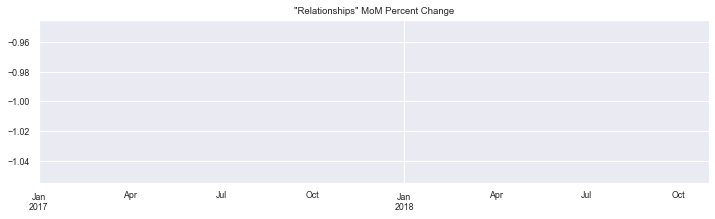

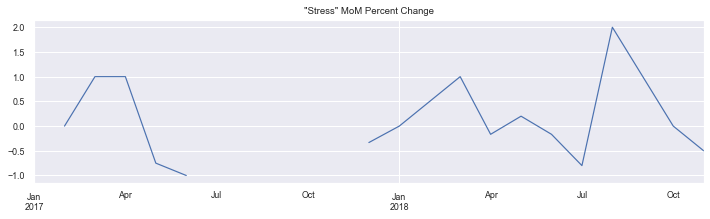

In [26]:
# i want to see the relative percent change difference from the previous month
# where JAN 2017 should reflect 0% because no change

def percent_change(x):
    if len(x):
        return (x[-1]-x[0])/x[0]

for col in test_cols:
    plt.figure(figsize = (12, 3))
    plt.style.use('ggplot')
    sns.set(font_scale = 0.8)

    # calculating subreddit count and month-over-month percentage change
    test_df[col].resample("M").sum().pct_change().plot(kind = "line", linewidth = 1.2)
    plt.xlabel(None)

    plt.title(f'"{col.title()}" MoM Percent Change')
    plt.show()

### ``observations/insights:``

- no trend line or breaks in plotted 'MoM percent change' represents no change from the prior month
- certain topics have relative "significant" MoM percentage changes
- it appears that there are no "distinguishable" trends accross the subreddit topics and when they are discussed/referenced throughout the studied period
- one additional step that we could consider taking is studying potential "anomalous" trends in the studied period and what real-world events may have taken place during these periods


``Since the 'subreddit' topics/labels are typically found within the context of the text -- I will forgo the idea of attempting to predict these classifications and solely focus on predicting 'stress'``

-----

In [27]:
# let's clean and glance at the text data

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2838 entries, 2017-01-01 12:36:58 to 2018-11-19 01:54:20
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype    
---  ------               --------------  -----    
 0   label                2838 non-null   int64    
 1   post_id              2838 non-null   object   
 2   subreddit            2838 non-null   object   
 3   sentence_range       2838 non-null   object   
 4   text                 2838 non-null   object   
 5   id                   2838 non-null   int64    
 6   confidence           2838 non-null   float64  
 7   social_karma         2838 non-null   int64    
 8   syntax_ari           2838 non-null   float64  
 9   sentiment            2838 non-null   float64  
 10  social_upvote_ratio  2838 non-null   float64  
 11  social_num_comments  2838 non-null   int64    
 12  month_year           2838 non-null   period[M]
dtypes: float64(4), int64(4), object(4), period[M](1)
memory usage: 310.4+ KB


In [28]:
# check the head first

df.head(2)

,label,post_id,subreddit,sentence_range,text,id,confidence,social_karma,syntax_ari,sentiment,social_upvote_ratio,social_num_comments,month_year
social_timestamp,,,,,,,,,,,,,
2017-01-01 12:36:58,1,5lezhz,domestic_violence,"[14, 19]",He came after me a few times so I got away and...,313,0.571429,4,0.531035,0.076333,0.84,3,2017-01
2017-01-01 12:36:58,1,5lezhz,domestic_violence,"(5, 10)","We will get through this and I am determined, ...",31536,0.857143,4,8.679730,0.047222,0.84,3,2017-01


In [29]:
# cleaning the 'text' column data
# consider if it's necessary to remove words <= 2; as there are pronouns that might have 'stress' related implications (e.g., he, we, etc.)

df["text"] = df["text"].apply(mass_text_clean)
df.head() # check out!

,label,post_id,subreddit,sentence_range,text,id,confidence,social_karma,syntax_ari,sentiment,social_upvote_ratio,social_num_comments,month_year
social_timestamp,,,,,,,,,,,,,
2017-01-01 12:36:58,1,5lezhz,domestic_violence,"[14, 19]",came time got away called cop wa arrested rest...,313,0.571429,4,0.531035,0.076333,0.84,3,2017-01
2017-01-01 12:36:58,1,5lezhz,domestic_violence,"(5, 10)",get determined even mean going shelter get aff...,31536,0.857143,4,8.679730,0.047222,0.84,3,2017-01
2017-01-01 18:35:06,1,5lge1y,anxiety,"(0, 5)",currently constant state heart palptations wok...,7419,1.000000,14,7.822923,-0.083333,0.94,8,2017-01
2017-01-03 16:10:28,1,5lspep,abuse_survivors,"(5, 10)",wa fucking panic attack payed done went thrift...,18404,1.000000,5,0.633660,-0.466667,0.86,7,2017-01
2017-01-03 22:13:10,1,5luwz3,almost_homeless,"[10, 15]",afraid sell house sure future hold family made...,1804,0.800000,5,2.823077,-0.401250,0.65,15,2017-01


In [30]:
# let's solely focus on text and the target output == "label"

df = df[[ 
    "label",
    "subreddit",
    "text"
        ]].reset_index(drop = True)

df.head()

,label,subreddit,text
0,1,domestic_violence,came time got away called cop wa arrested rest...
1,1,domestic_violence,get determined even mean going shelter get aff...
2,1,anxiety,currently constant state heart palptations wok...
3,1,abuse_survivors,wa fucking panic attack payed done went thrift...
4,1,almost_homeless,afraid sell house sure future hold family made...


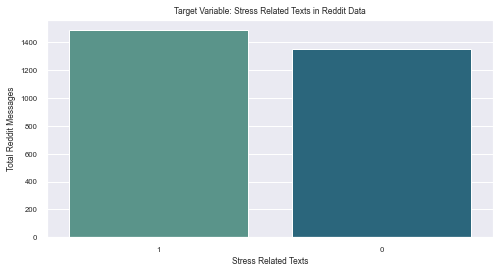

In [31]:
# what's the target variable proportion/breakdown

plt.figure(figsize = (8,4))
sns.set(font_scale = 0.7)

ax = sns.countplot( 
    data = df,
    x = "label",
    order = df["label"].value_counts().index,
    palette = "crest"
)

plt.title("Target Variable: Stress Related Texts in Reddit Data")
plt.ylabel("Total Reddit Messages")
plt.xlabel("Stress Related Texts")
plt.show()

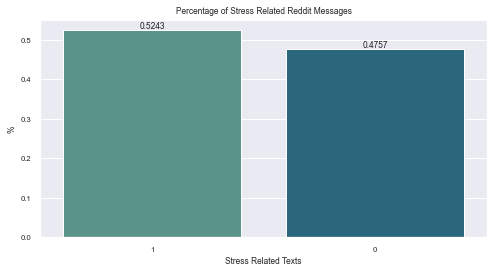

In [32]:
# let's view the target variable as a percentage of total

plt.figure(figsize = (8,4))
sns.set(font_scale = 0.7)

ax = sns.barplot( 
    data = df,
    y = df["label"].value_counts(normalize = True).values,
    x = df["label"].value_counts(normalize = True).index,
    order = df["label"].value_counts(normalize = True).index,
    palette = "crest"
)

ax.bar_label(ax.containers[0], fmt = '%.4f')
plt.title("Percentage of Stress Related Reddit Messages")
plt.ylabel("%")

plt.xlabel("Stress Related Texts")
plt.show()

In [33]:
# showing labels/target as count and percentage of total

prepare.show_counts_and_ratios(df, "label")

,n,percent
1,1488,0.524313
0,1350,0.475687


----
### ``Splitting the Data``

In [34]:
# split the reddit "stress" dataset into train, validate, and test

train, validate, test = prepare.train_validate_test_split(df, "label")

train shape: (1589, 3)
validate shape: (681, 3)
test shape: (568, 3)


In [35]:
train.head()

,label,subreddit,text
48,1,anxiety,suffered mild disorder diagnosed 4 year logica...
1648,1,abuse_survivors,feel like cannot trust anyone truly feel never...
923,0,relationships,thing enjoy see big deal seems perceive grand ...
1238,0,relationships,talk morning life went next year would continu...
2760,0,ptsd,everyone edit title say reading symptom btw fe...


In [36]:
# viewing reddit text data by subreddit topics

train.subreddit.unique().tolist()

['anxiety',
 'abuse_survivors',
 'relationships',
 'ptsd',
 'almost_homeless',
 'domestic_violence',
 'food_pantry',
 'homeless',
 'assistance',
 'stress']

In [37]:
# splitting the text by subreddit

all_text = ' '.join(train.text).split()

almost_homeless_text = ' '.join(train.text[train["subreddit"] == 'almost_homeless']).split()

assistance_text = ' '.join(train.text[train["subreddit"] == 'assistance']).split()

anxiety_text = ' '.join(train.text[train["subreddit"] == 'anxiety']).split()

domestic_violence_text = ' '.join(train.text[train["subreddit"] == 'domestic_violence']).split()

food_pantry_text = ' '.join(train.text[train["subreddit"] == 'food_pantry']).split()

homeless_text = ' '.join(train.text[train["subreddit"] == 'homeless']).split()

ptsd_text = ' '.join(train.text[train["subreddit"] == 'ptsd']).split()

relationships_text = ' '.join(train.text[train["subreddit"] == 'relationships']).split()

stress_text = ' '.join(train.text[train["subreddit"] == 'stress']).split()

survivors_text = ' '.join(train.text[train["subreddit"] == 'abuse_survivors']).split()

In [38]:
# what about individual word counts?

all_freq = pd.Series(all_text).value_counts()

almost_homeless_freq = pd.Series(almost_homeless_text).value_counts()

assistance_freq = pd.Series(assistance_text).value_counts()

axiety_freq = pd.Series(anxiety_text).value_counts()

domestic_violence_freq = pd.Series(domestic_violence_text).value_counts()

food_pantry_freq = pd.Series(food_pantry_text).value_counts()

homeless_freq = pd.Series(homeless_text).value_counts()

ptsd_freq = pd.Series(ptsd_text).value_counts()

relationships_freq = pd.Series(relationships_text).value_counts()

stress_freq = pd.Series(stress_text).value_counts()

survivors_freq = pd.Series(survivors_text).value_counts()

In [40]:
# viewing total number of unique words by subreddit topic

subreddits = [
    'all_text',
    'almost_homeless_text',
    'assistance_text',
    'anxiety_text',
    'domestic_violence_text',
    'food_pantry_text',
    'homeless_text',
    'ptsd_text',
    'relationships_text',
    'stress_text',
    'survivors_text']

frames = [
    all_text,
    almost_homeless_text,
    assistance_text,
    anxiety_text,
    domestic_violence_text,
    food_pantry_text,
    homeless_text,
    ptsd_text,
    relationships_text,
    stress_text,
    survivors_text]

for i in range(len(subreddits)):
        print(subreddits[i] + ": " + str(len(frames[i])))
        print('--------------------------------')

all_text: 63387
--------------------------------
almost_homeless_text: 1924
--------------------------------
assistance_text: 6644
--------------------------------
anxiety_text: 10708
--------------------------------
domestic_violence_text: 6936
--------------------------------
food_pantry_text: 792
--------------------------------
homeless_text: 3581
--------------------------------
ptsd_text: 13325
--------------------------------
relationships_text: 12587
--------------------------------
stress_text: 1471
--------------------------------
survivors_text: 5419
--------------------------------


In [ ]:
# visualize subreddit topics by total number of unique words
# place "all text" as benchmark plot



In [ ]:
# work on visualizing/building wordclouds "n-grams" by subreddit topic (eg., single words, bi, tri-gram, etc.)

